In [2]:
import glob
import os
import os.path as osp
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# ImageNet用のTransformを作成
---

In [3]:
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

## 実行テスト

In [8]:
os.listdir('./keyaki_member_data_edited/train/Hirate_Yurina')

['00046.jpg',
 '00085.jpg',
 '00091.jpg',
 '00084.jpg',
 '00053.jpg',
 '00051.jpg',
 '00045.jpg',
 '00079.jpg',
 '00092.jpg',
 '00086.jpg',
 '00087.jpg',
 '00078.jpg',
 '00044.jpg',
 '00050.jpg',
 '20031.jpg',
 '.DS_Store',
 '00054.jpg',
 '00097.jpg',
 '00083.jpg',
 '00082.jpg',
 '00041.jpg',
 '00055.jpg',
 '00069.jpg',
 '00057.jpg',
 '00080.jpg',
 '00095.jpg',
 '00056.jpg',
 '00042.jpg',
 '00025.jpg',
 '00031.jpg',
 '00019.jpg',
 '00018.jpg',
 '00032.jpg',
 '00026.jpg',
 '00037.jpg',
 '00023.jpg',
 '00036.jpg',
 '10031.jpg',
 '00008.jpg',
 '00020.jpg',
 '00034.jpg',
 '00035.jpg',
 '00021.jpg',
 '00009.jpg',
 '00004.jpg',
 '00038.jpg',
 '00005.jpg',
 '00013.jpg',
 '00007.jpg',
 '00006.jpg',
 '00012.jpg',
 '00016.jpg',
 '00002.jpg',
 '00003.jpg',
 '00017.jpg',
 '00001.jpg',
 '00015.jpg',
 '00000.jpg',
 '00028.jpg',
 '00067.jpg',
 '00098.jpg',
 '00099.jpg',
 '00072.jpg',
 '00066.jpg',
 '00070.jpg',
 '00058.jpg',
 '00059.jpg',
 '00065.jpg',
 '00071.jpg',
 '10048.jpg',
 '10058.jpg',
 '0004

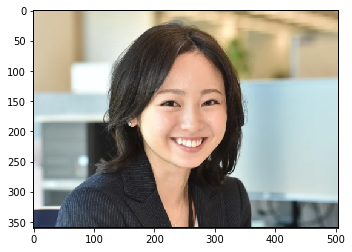

torch.Size([3, 224, 224])


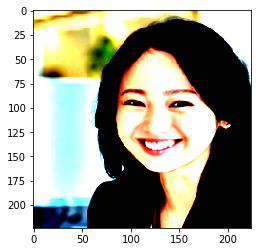

In [94]:
image_file_path = './keyaki_member_data_edited/val/Imaizumi_Yui/000047.png'
img = Image.open(image_file_path).convert('RGB')

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

print(img_transformed.size())

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

# ファイルパスを格納するリストを作成する関数
---

In [9]:
def make_datapath_list(rootpath='./data/', phase='train'):
    
    target_path = osp.join(rootpath, phase, '*/*.*')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

## 実行テスト

In [10]:
rootpath = './keyaki_member_data_edited/'
train_list = make_datapath_list(rootpath, 'train')
val_list = make_datapath_list(rootpath, 'val')

./keyaki_member_data_edited/train/*/*.*
./keyaki_member_data_edited/val/*/*.*


# DataSetを作成

In [11]:
class KeyakiDatasest(data.Dataset):
    
    def __init__(self, file_list, label_list, transform=None, phase='train'):
        self.file_list = file_list
        self.label_list = label_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB')
        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-2]
        label = label_list.index(label)
        
        return img_transformed, label

## 実行テスト

In [12]:

label_list = ['Hirate_Yurina', 'Imaizumi_Yui', 'Nagahama_Neru']

train_dataset = KeyakiDatasest(train_list, label_list, transform=transform, phase='train')
val_dataset = KeyakiDatasest(val_list, label_list, transform=transform, phase='val')

print(len(val_dataset))
val_dataset[14]

NameError: name 'transform' is not defined

# DataLoaderを作成
---

In [97]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([2, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 0, 0,
        1, 1, 2, 2, 0, 2, 1, 2])


# ネットワークモデルを作成する
---

In [10]:
use_pretrained = True
net = models.mobilenet_v2(pretrained=use_pretrained)

out_features = 5
net.classifier[1] = nn.Linear(in_features=1280, out_features=out_features)

net.train()
for name, param in net.named_parameters():
    print(name)
print('ネットワーク設定完了：学習済みの重みをロードし，訓練モードに設定しました')

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.3.conv.0.0.weight
features.3.conv.0.1.weight
features.3.conv.0.1.bias
features.3.conv.1.0.weight
features.3.conv.1.1.weight
features.3.conv.1.1.bias
features.3.conv.2.weight
features.3.conv.3.weight
features.3.conv.3.bias
features.4.conv.0.0.weight
features.4.conv.0.1.weight
features.4.conv.0.1.bias
features.4.conv.1.0.weight
features.4.conv.1.1.weight
features.4.conv.1.1.bias
features.4.conv.2.weight
features.4.conv.3.weight
features.4.conv.3.bias
features.5.conv.0.0.weight
features.5.conv.0.1.weight
features.5.conv.0.1.bias
features.5.conv.1.

## 損失関数の定義

In [100]:
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [110]:
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

def get_param_name(n):
    return ['classifier.%d.weight' %n, 'classifier.%d.bias' %n]

update_params_name_1 = ['features']
update_params_name_2 = get_param_name(0) + get_param_name(3)
update_params_name_3 = get_param_name(6)

for name, param in net.named_parameters():
    if update_params_name_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print('params_to_update_1に格納:', name)
    
    elif name in update_params_name_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print('params_to_update_2に格納:', name)
        
    elif name in update_params_name_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print('params_to_update_3に格納:', name)
    
    else:
        param.requires_grad = False
        print('勾配計算なし．学習しない:', name)

params_to_update_1に格納: features.0.weight
params_to_update_1に格納: features.0.bias
params_to_update_1に格納: features.2.weight
params_to_update_1に格納: features.2.bias
params_to_update_1に格納: features.5.weight
params_to_update_1に格納: features.5.bias
params_to_update_1に格納: features.7.weight
params_to_update_1に格納: features.7.bias
params_to_update_1に格納: features.10.weight
params_to_update_1に格納: features.10.bias
params_to_update_1に格納: features.12.weight
params_to_update_1に格納: features.12.bias
params_to_update_1に格納: features.14.weight
params_to_update_1に格納: features.14.bias
params_to_update_1に格納: features.17.weight
params_to_update_1に格納: features.17.bias
params_to_update_1に格納: features.19.weight
params_to_update_1に格納: features.19.bias
params_to_update_1に格納: features.21.weight
params_to_update_1に格納: features.21.bias
params_to_update_1に格納: features.24.weight
params_to_update_1に格納: features.24.bias
params_to_update_1に格納: features.26.weight
params_to_update_1に格納: features.26.bias
params_to_update_1に格納: f

In [113]:
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3},
], momentum=0.9)

## 学習・検証を実施

In [159]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('使用デバイス:', device)
    
    net.to(device)
    
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(num_epochs):
        print('Epoch %d/%d' %(epoch+1, num_epochs))
        print('---------')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if epoch == 0 and phase == 'train':
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('%s Loss: %.4f Acc: %.4f' %(phase, epoch_loss, epoch_acc))

In [160]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)




  0%|          | 0/1 [00:00<?, ?it/s]

使用デバイス: cpu
Epoch 1/2
---------





100%|██████████| 1/1 [00:14<00:00, 14.54s/it]



  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 1.0866 Acc: 0.4000
Epoch 2/2
---------





 25%|██▌       | 1/4 [00:54<02:44, 54.67s/it]


 50%|█████     | 2/4 [01:51<01:50, 55.45s/it]


 75%|███████▌  | 3/4 [02:50<00:56, 56.23s/it]


100%|██████████| 4/4 [03:17<00:00, 49.38s/it]



  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.1490 Acc: 0.3451





100%|██████████| 1/1 [00:16<00:00, 16.42s/it]

val Loss: 1.0500 Acc: 0.4667


## 学習したネットワークを保存・ロード

In [143]:
save_path = './weights_keyaki_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

32

In [170]:
import time
start = time.time()
a = [i for i in range(100,0,-1)]
for i in range(100):
    a.sort()
end = time.time()
print(end-start)

0.0023758411407470703


14.377168893814087
